# FAI: Deep Reinforcement Learning

In [1]:
import keras
import numpy as np
import scipy
import io
import base64
from IPython.display import HTML
import skvideo
#skvideo.setFFmpegPath("/anaconda3/lib/python3.6/skvideo")
import skvideo.io
import cv2
import json
import matplotlib.pyplot as plt
import Map
from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,Reshape,BatchNormalization,Dropout,Flatten, Convolution2D
from keras.utils import np_utils

Using TensorFlow backend.


In [205]:
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        #grid_size = grid_size+4
        self.grid_size = grid_size+4
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        #self.board = np.zeros((grid_size,grid_size))
        #self.position = np.zeros((grid_size,grid_size))
        #self.malus_position = np.zeros((grid_size,grid_size))
        
        self.board_humain = np.zeros((grid_size,grid_size))
        self.board_vampire = np.zeros((grid_size,grid_size))
        self.board_warevolves = np.zeros((grid_size,grid_size))
        self.board = {"human": self.board_humain, "vampire": self.board_vampire, "warevolves": self.board_warevolves}
        
        # changement
        self.board_vampire_malus = np.zeros((grid_size,grid_size))
        self.board_warevolves_malus = np.zeros((grid_size,grid_size))
        self.malus = {"vampire": self.board_vampire_malus, "warevolves": self.board_warevolves_malus}
        
        # coordinate of the vampires
        self.vampire_x = 0
        self.vampire_y = 0
        
        # coordinate of the warevolves
        self.warevolves_x = 1
        self.warevolves_y = 1
        
        self.coordinates ={"vampire": np.array((self.vampire_x, self.vampire_y)), "warevolves": np.array((self.warevolves_x, self.warevolves_y))}

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw) ######################################################
        print()

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board["human"]>0,:] = 256
        b[self.coordinates["warevolves"][0], self.coordinates["warevolves"][1], 2] = 256
        b[self.coordinates["vampire"][0], self.coordinates["vampire"][1], 0]= 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action, species, train=True): #train
        """This function returns the new state, reward and decides if the
        game ends."""
        
        self.get_frame(int(self.t))
        
        if(species == "vampire"):
            other_species = "warevolves"
        else:
            other_species = "vampire"
        
        count_species = self.board[species][self.coordinates[species][0], self.coordinates[species][1]]
        
        #print("Start: " + species + ": " + str(count_species))
        
        self.board[species][self.coordinates[species][0], self.coordinates[species][1]] = 0
        
        reward = 0
        
        game_over = False
        
        not_go_out_of_map = 1
        
        # right
        if action == 0:
            if self.coordinates[species][0] == self.grid_size-3:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
            else:
                self.coordinates[species][0] = self.coordinates[species][0] + 1
        # left
        elif action == 1:
            if self.coordinates[species][0] == 2:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
            else:
                self.coordinates[species][0] = self.coordinates[species][0]-1
        # north
        elif action == 2:
            if self.coordinates[species][1] == 2:
                self.coordinates[species][1] = self.coordinates[species][1] 
                reward -= not_go_out_of_map
                #game_over = True
            else:
                self.coordinates[species][1] = self.coordinates[species][1] - 1
        #south
        elif action == 3:
            if self.coordinates[species][1] == self.grid_size - 3:
                self.coordinates[species][1] = self.coordinates[species][1]
                reward -= not_go_out_of_map
                #game_over = True
            else:
                self.coordinates[species][1] = self.coordinates[species][1] + 1

        # North Est (droite)
        elif action == 4:
            if self.coordinates[species][1] == 2:
                self.coordinates[species][1] = self.coordinates[species][1]
                reward -= not_go_out_of_map
                #game_over = True
            if self.coordinates[species][0] == self.grid_size-3:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
            if(not(self.coordinates[species][1] == 2) and not(self.coordinates[species][0] == self.grid_size-3)):
                self.coordinates[species][0] = self.coordinates[species][0] + 1
                self.coordinates[species][1] = self.coordinates[species][1] - 1

        # North ouest 
        elif action == 5:
            if self.coordinates[species][1] == 2:
                self.coordinates[species][1] = self.coordinates[species][1]
                reward -= not_go_out_of_map
                #game_over = True
            if self.coordinates[species][0] == 2:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
            if(not(self.coordinates[species][1] == 2) and not(self.coordinates[species][0] == 2)):
                self.coordinates[species][0] = self.coordinates[species][0] - 1
                self.coordinates[species][1] = self.coordinates[species][1] - 1

        # Sud ouest 
        elif action == 6:
            if self.coordinates[species][1] == self.grid_size-3:
                self.coordinates[species][1] = self.coordinates[species][1] 
                reward -= not_go_out_of_map
                #game_over = True
            if self.coordinates[species][0] == 2:
                self.coordinates[species][0] = self.coordinates[species][0] 
                reward -= not_go_out_of_map
                #game_over = True
            if(not(self.coordinates[species][1] == self.grid_size-3) and not(self.coordinates[species][0] == 2)):
                self.coordinates[species][0] = self.coordinates[species][0] - 1
                self.coordinates[species][1] = self.coordinates[species][1] + 1

        # Sud est        
        elif action == 7:
            if self.coordinates[species][1] == self.grid_size-3:
                self.coordinates[species][1] = self.coordinates[species][1] 
                reward -= not_go_out_of_map
                #game_over = True
            if self.coordinates[species][0] == self.grid_size - 3:
                self.coordinates[species][0] = self.coordinates[species][0] 
                reward -= not_go_out_of_map
                #game_over = True
            if (not(self.coordinates[species][1] == self.grid_size-3) and not(self.coordinates[species][0] == self.grid_size - 3)):
                self.coordinates[species][0] = self.coordinates[species][0] + 1
                self.coordinates[species][1] = self.coordinates[species][1] + 1
        else:
            RuntimeError('Error: action not recognized')
        
        species_coor_1, species_coor_2 = self.coordinates[species][0],self.coordinates[species][1]
        
        #print(species_coor_1,species_coor_2)
        
        reward = reward - self.malus[species][species_coor_1, species_coor_2] 
        
        self.malus[species][species_coor_1, species_coor_2] = 4
        
        self.board[species][species_coor_1, species_coor_2] = count_species
        
        count_other_species = self.board[other_species][species_coor_1, species_coor_2]
        
        self.t = self.t + 1
            
        p_win = 1
        
        if(self.board["human"][species_coor_1,species_coor_2] > 0):
            n_species = self.board[species][species_coor_1,species_coor_2]
            n_human = self.board["human"][species_coor_1,species_coor_2]
            
            if(n_species > n_human):
                self.board[species][species_coor_1,species_coor_2] += self.board["human"][species_coor_1,species_coor_2]
                self.board["human"][species_coor_1,species_coor_2] = 0
            else:
                p_win = n_species/(n_human*2)
                threshold = np.random.uniform(0, 1)
                
                # win
                if(p_win >= threshold):
                    self.board[species][species_coor_1,species_coor_2] = np.random.binomial(n_species, p_win)
                    self.board[species][species_coor_1,species_coor_2] += np.random.binomial(n_human, p_win)
                    self.board["human"][species_coor_1,species_coor_2] = 0
                
                # loose
                else:
                    self.board[species][species_coor_1,species_coor_2] = 0
                    self.board["human"][species_coor_1,species_coor_2] = np.random.binomial(n_human, 1-p_win)
                    
        
        elif(self.board[other_species][species_coor_1,species_coor_2] > 0): 
            n_species = self.board[species][species_coor_1,species_coor_2]
            n_other_species = self.board[other_species][species_coor_1,species_coor_2]
            
            if(n_species >= 1.5*n_other_species):
                self.board[other_species][species_coor_1,species_coor_2] = 0 
            
            elif(1.5*n_species <= n_other_species):  
                self.board[species][species_coor_1,species_coor_2] = 0 
            
            elif(n_species <= n_other_species and n_species > n_other_species/1.5):
                p_win = n_species/(n_other_species*2)
                threshold = np.random.uniform(0, 1)
                
                # win
                if(p_win >= threshold):
                    self.board[species][species_coor_1,species_coor_2] = np.random.binomial(n_species, p_win)
                    self.board[other_species][species_coor_1,species_coor_2] = 0
                
                # loose
                else:
                    self.board[species][species_coor_1,species_coor_2] = 0
                    self.board[other_species][species_coor_1,species_coor_2] = np.random.binomial(n_other_species, 1-p_win)
                
            elif(n_species > n_other_species and n_species < 1.5*n_other_species):
                p_win = n_species/n_other_species - 0.5
                threshold = np.random.uniform(0, 1)
                
                # win
                if(p_win >= threshold):
                    self.board[species][species_coor_1,species_coor_2] = np.random.binomial(n_species, p_win)
                    self.board[other_species][species_coor_1,species_coor_2] = 0
                
                # loose
                else:
                    self.board[species][species_coor_1,species_coor_2] = 0
                    self.board[other_species][species_coor_1,species_coor_2] = np.random.binomial(n_other_species, 1-p_win)
            
            # chagement
            reward = reward - (self.board[other_species][species_coor_1,species_coor_2] - count_other_species)*p_win
            
            if(self.board[other_species][species_coor_1,species_coor_2] == 0):
                reward += 1*p_win
                game_over = True
                                
        #print("End: " + species + ": " + str(self.board[species][species_coor_1,species_coor_2]))
        
        reward = reward + (self.board[species][species_coor_1,species_coor_2] - count_species)*p_win
        
        if(self.board[species][species_coor_1,species_coor_2] == 0):
            reward -= 1*(1 - p_win)
        
        # changement
        game_over = game_over or self.t > self.max_time or self.board[species][species_coor_1,species_coor_2] == 0 
            
        state = np.concatenate((self.malus[species].reshape(self.grid_size, self.grid_size,1),
                                self.board["human"].reshape(self.grid_size, self.grid_size,1),
                                self.board["vampire"].reshape(self.grid_size, self.grid_size,1)),axis=2) #species
                                #self.board["warevolves"].reshape(self.grid_size, self.grid_size,1)),axis=2) #other species
        
        state = state[species_coor_1 - 2:species_coor_1 + 3, species_coor_2 - 2:species_coor_2 + 3, :]
        #reward = np.clip(reward,-1,1)
        
        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

            
        self.vampire_x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.vampire_y = np.random.randint(3, self.grid_size-3, size=1)[0]
        
        self.warevolves_x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.warevolves_y = np.random.randint(3, self.grid_size-3, size=1)[0]
        
        self.coordinates ={"vampire": np.array((self.vampire_x, self.vampire_y)), "warevolves": np.array((self.warevolves_x, self.warevolves_y))}

        self.board_human = 3*np.random.binomial(1,self.temperature,size=self.grid_size**2) #(1+np.random.poisson(1,size=self.grid_size**2))
        self.board_human = self.board_human.reshape(self.grid_size,self.grid_size)
        
        self.board_human[self.vampire_x, self.vampire_y] = 0
        self.board_human[self.warevolves_x, self.warevolves_y] = 0    
        
        self.board_human[0:2, :] = 0
        self.board_human[:, 0:2] = 0
        self.board_human[-2:, :] = 0
        self.board_human[:, -2:] = 0
        
        #print(self.board_human)
        
        init_vampire =  10 #+ np.random.poisson(4)
        init_warevolves = 5 #+ np.random.poisson(4)
        
        #print(self.board_human)
        #print("vampire: " + str(init_vampire))
        #print("warevolves: " + str(init_warevolves))
            
        self.board_vampire = np.zeros((self.grid_size,self.grid_size))
        self.board_vampire[self.vampire_x, self.vampire_y] = init_vampire
            
        self.board_warevolves = np.zeros((self.grid_size,self.grid_size))
        self.board_warevolves[self.warevolves_x, self.warevolves_y] = init_warevolves
        
        self.board = {"human": self.board_human, "vampire": self.board_vampire, "warevolves":self.board_warevolves}

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))
        
        self.t = 0
        
        # changement
        self.board_vampire_malus = np.zeros((self.grid_size, self.grid_size))
        self.board_warevolves_malus = np.zeros((self.grid_size, self.grid_size))
        self.malus = {"vampire": self.board_vampire_malus, "warevolves": self.board_warevolves_malus}

        state = np.concatenate((self.malus["vampire"].reshape(self.grid_size, self.grid_size,1),
                                self.board["human"].reshape(self.grid_size, self.grid_size,1),
                                self.board["vampire"].reshape(self.grid_size, self.grid_size,1)),axis=2) #species
                                #self.board["warevolves"].reshape(self.grid_size, self.grid_size,1)),axis=2) #other species
        
        ####triming####
        state = state[self.vampire_x - 2:self.vampire_x + 3, self.vampire_y - 2:self.vampire_y + 3, :]
        
        return state

In [206]:
class Memory(object):
    def __init__(self, max_memory=10000):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory)>=self.max_memory:
            self.memory[np.random.randint(self.max_memory)]= m
        else:
            self.memory.append(m)

    def random_access(self):
        return self.memory[np.random.randint(len(self.memory))]


class AI_train(object):
    
    def __init__(self, SET, HME, MAP, grid_size=10, lr=0.1, memory_size=1000, batch_size = 32, n_state=3):
        
        ######
        self.map = Map(SET, HME, MAP)
        self.coor = [HME[0],HME[1], MAP[HME[0],HME[1],self.creature]]
        
        
        ######
        # Q learning parameters
        self.discount = 0.99
        self.nb_actions = 4
        self.memory = Memory(memory_size)
        self.batch_size = batch_size
        self.grid_size = grid_size+4
        self.history = []
        self.n_state = n_state
        self.loss = []

        # Net declaration
        model = Sequential()
        model.add(Convolution2D(32, (2, 2), input_shape=(5,5,self.n_state))) 
        model.add(Convolution2D(64, (2, 2))) 
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(Dense(self.nb_actions))
        model.add(Activation('tanh')) 
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        
        #model.add(Conv2D(32,8,strides=(1, 1),padding="valid",activation="relu",input_shape=(self.grid_size,self.grid_size,self.n_state)))
        #model.add(Conv2D(64,4,strides=(1, 1),padding="valid", activation="relu"))
        #model.add(Flatten())
        #model.add(Dense(512))
        #model.add(Activation('relu'))
        #model.add(Dense(self.nb_actions))
        #model.add(Activation('linear')) 
        #model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        #self.model = model
        model.summary()
        
    def act(self, UPD, epsilon):
        
        self.map.update(UPD)
        self.map
        
        state = np.zeros(21,21,3)
        true_coord1,true_coord = np.clip(self.coor-21, 
        state = self.map.grid[self.coor-21]
        
        action = self.model.predict(state[np.newaxis,:,:,:])
        action = np.argmax(action)
            
        return action
    
    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        
        #Q-Learning with experience replay implementation

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size,5,5,self.n_state))
        #input_states = np.zeros((self.batch_size,self.grid_size,self.grid_size,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            
            batch = self.memory.random_access() #randomly selecting episodes
            
            if batch[4]: #game_over
                input_states[i] = batch[0]
                target_q[i,:] = self.model.predict(batch[0].reshape((1,5,5,self.n_state)))
                #target_q[i,:] = self.model.predict(batch[0].reshape((1,self.grid_size,self.grid_size,self.n_state)))
                target_q[i,int(batch[2])] = batch[3]
            else:
                input_states[i] = batch[0]
                target_q[i,:] = self.model.predict(batch[0].reshape((1,5,5,self.n_state)))
                #target_q[i,:] = self.model.predict(batch[0].reshape((1,self.grid_size,self.grid_size,self.n_state)))
                target_q[i,int(batch[2])] = batch[3] + self.discount*np.max(self.model.predict(batch[1].reshape((1,5,5,self.n_state))))
                #target_q[i,int(batch[2])] = batch[3] + self.discount*np.max(self.model.predict(batch[1].reshape((1,self.grid_size,self.grid_size,self.n_state))))
        
        target_q = target_q
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        #NB this is made useless by the squashing operation
        loss = self.model.train_on_batch(input_states, target_q)
        self.loss.append(loss)

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

In [207]:
def Connect_and_play(env, train=True):
     
    def decode_and_play(agent,state,species,epsilon):

            action = agent.act(state,epsilon)
            prev_state = state
            state, reward, Finished = env.act(action, species)

            # Update the counters
            if reward > 0:
                win[species] = win[species] + reward
            if reward < 0:
                lose[species] = lose[species] - reward

            # Apply the reinforcement strategy
            #agent.reinforce(prev_state, state,  action, reward, Finished)
            return state, Finished, reward     

    Finished = False

####### TRAINING LOCALLY ########

    if train==True:
        
        nb_of_players =2
        env.reset()
        species = 'vampire'
        observations = []
        replaybuffer1 = []
        replaybuffer2 = []
        prefix = "ciao"
        score = dict(zip(['vampire','warevolves'],[0,0]))
        epoch=50
        epsilon = 0
        agent1= AI_train()
        #agent2= AI_train()
        win = dict(zip(['vampire','warevolves'],[0,0]))
        lose = dict(zip(['vampire','warevolves'],[0,0]))
        reward_list = {}
        
        agent1.load(name_weights='cnn_train_exploremodel.h5',name_model='cnn_train_exploremodel.json')
        
        for e in range(epoch):
            reward_list[e]=[]
            # At each epoch, we restart to a fresh game and get the initial state
            state = env.reset()
            # This assumes that the games will terminate
            Finished = False
            
            #if(epsilon > 0.3):
            #    epsilon = epsilon*0.99
            
            #if(e == 20):
            #    epsilon = 0.1
            
            while not Finished:
                if species == 'vampire': 
                    state, Finished, reward = decode_and_play(agent1,state,species,epsilon)
                    reward_list[e].append(reward)
                    #species = 'warevolves'
                #else:
                    #state, Finished = decode_and_play(agent2,state,species,epsilon)
                    #species = 'vampire'

            if e % 5 == 0:
                env.draw(prefix+str(e))
                print(e)
                
            for specie in ['vampire','warevolves']:
                score[specie] = round(win[specie]-lose[specie],2)
            
            print("Epoch {:03d}/{:03d} | score vampire {:.4f} score warevolves {:.4f}"
                  .format(e, epoch, score['vampire'], score['warevolves']))
            
            win = dict(zip(['vampire','warevolves'],[0,0]))
            lose = dict(zip(['vampire','warevolves'],[0,0]))
            
            plt.plot(agent1.loss)
            #plt.plot(agent2.loss)

            #score += win-lose

            #print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
            #  .format(e, epoch, loss, win, lose, win-lose))
            agent1.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
                
###################### COMPETITION CODE ###########################

    elif train == False:
        
        HOST = "localhost"
        PORT = "5555"
        path='tobedefined'
        
        runprog = subprocess.Popen(r"C:\Users\Utilisateur\Documents\AI\VampiresVSWerewolvesGameServer.exe")
        #Connection to the server
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((HOST, int(PORT)))
        sock.send("NME".encode("ascii"))
        sock.send(struct.pack("1B", 1))
        sock.send("1".encode("ascii"))
           
        def decode_and_play(self, sock):
            
            data = bytes()
            while len(data) < 3:
                time.sleep(0.02)
                data += sock.recv(3 - len(data))
                #Decoding package   
            header = data.decode("ascii")

            if header == "END":
                print("END")
                # ending the party and starting a new one
            elif header == "BYE":
                sock.close()
                time.sleep(1)
                runprog.kill()
                Finished = True
            # SET
            elif header == "SET":
                (height, width)= receive_data(sock, 2, "2B")

            #HUM
            elif header == "HUM":
                number_of_homes = receive_data(sock, 1, "1B")[0]
                homes_raw = receive_data(sock, number_of_homes * 2, "{}B".format(number_of_homes * 2))

            #HME
            elif header == "HME":
                start_position = tuple(receive_data(sock, 2, "2B"))
                #start_position=start_position[::-1]

            elif header == "MAP":
                number_map_commands = receive_data(sock,1, "1B")[0]
                map_commands_raw = receive_data(sock, number_map_commands * 5, "{}B".format(number_map_commands * 5))
                AI_inst = AI((height, width), start_position, map_commands_raw)

            elif header == "UPD":
                number_upd_commands = receive_data(sock,1, "1B")[0]
                upd_commands_raw = receive_data(sock, number_upd_commands * 5, "{}B".format(number_upd_commands * 5))
                MOV = AI_inst.act(upd_commands_raw)
                sock.send("MOV".encode("ascii"))
                sock.send(struct.pack("1B", len(MOV)))
                for i in MOV:
                    try:
                        sock.send(struct.pack("5B",i[0],i[1],i[2],i[3],i[4]))
                    except sock.error as e:
                        pass
            else: 
                print('Protocol Error')  
                
            while not Finished: 
                self.decode_and_play(sock)

    return agent1, reward_list#, agent2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 4, 4, 32)          416       
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten_37 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 1024)              590848    
_________________________________________________________________
activation_85 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 4)                 4100      
_________________________________________________________________
activation_86 (Activation)   (None, 4)                 0         
Total para

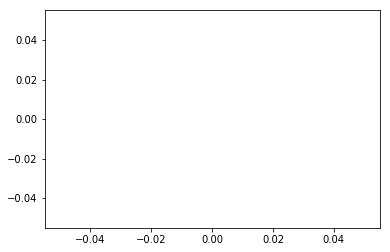

In [208]:
env = EnvironmentExploring(grid_size=10, max_time=100, temperature=0.2)
agent1, reward_list = Connect_and_play(env)

(None, 7, 7, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 7, 7, 32)          8224      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 4, 4, 64)          32832     
_________________________________________________________________
flatten_25 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_61 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 8)                 4104      
_________________________________________________________________
activation_62 (Activation)   (None, 8)                 0   

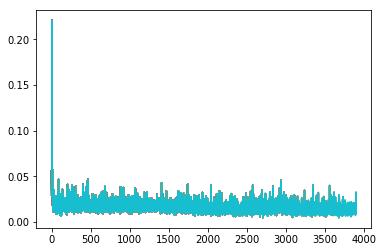

In [140]:
env = EnvironmentExploring(grid_size=10, max_time=100, temperature=0.2)
agent1, reward_list = Connect_and_play(env)


# paramètres 

# temperature = 0.2

# epoch=50

# epsilon = 1
# 0.99

# init_vampire =  10 
# init_warevolves = 10
# self.board_human = 3

# self.malus[species][species_coor_1, species_coor_2] += 4

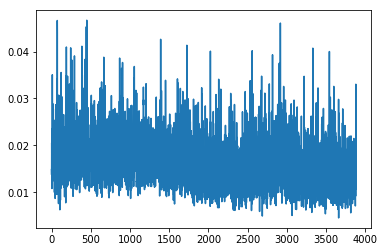

In [147]:
plt.plot(agent1.loss[15:])

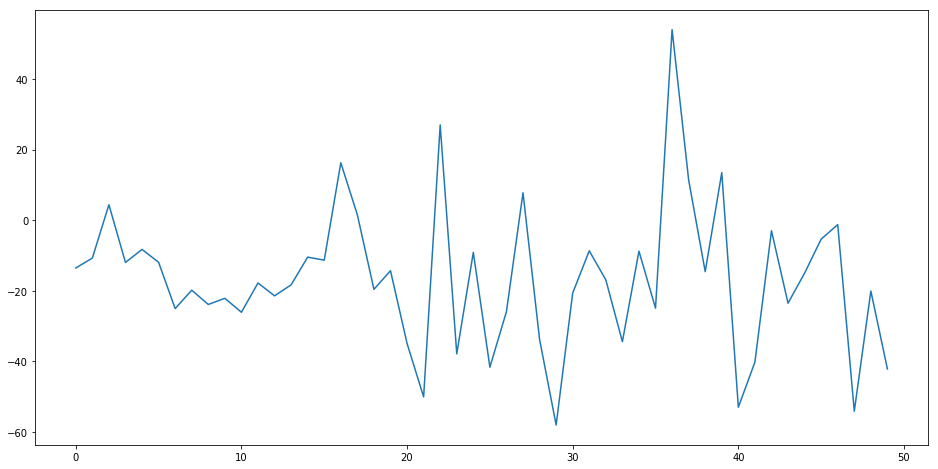

In [149]:
plt.figure(figsize=(16,8))
plt.plot([np.average(reward_list[e]) for e in range(50)])

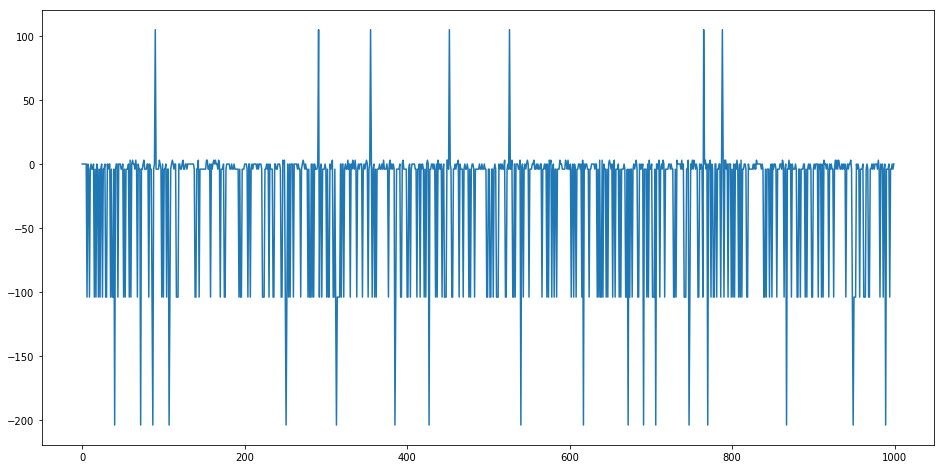

In [148]:
plt.figure(figsize=(16,8))
plt.plot(np.array([agent1.memory.memory[i][3] for i in range(len(agent1.memory.memory))]))

In [169]:
agent = AI_train()
agent.load(name_weights='ciaomodel.h5',name_model='ciaomodel.json')

(None, 7, 7, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 7, 7, 32)          8224      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 4, 4, 64)          32832     
_________________________________________________________________
flatten_29 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_69 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 8)                 4104      
_________________________________________________________________
activation_70 (Activation)   (None, 8)                 0   